#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [91]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [92]:
from collections import Counter
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

x = iris.data
y = iris.target


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

class NaiveBayes:
  def __init__(self, bins=4):
      self.priors = {}
      self.likelihoods = {}
      self.bins = bins

  def discretize_features(self, train_features: np.ndarray) -> np.ndarray:
      num_samples = train_features.shape[0]
      num_features = train_features.shape[1]
      discretized_features = np.zeros_like(train_features, dtype=int)
      for i in range(num_features):
        feature_column = train_features[:, i]
        discretized_feature = self.data_discretization(feature_column)
        discretized_features[:, i] = discretized_feature
      return discretized_features

  def calculate_priors(self, train_classes: np.ndarray) -> None:
      unique_classes, counts = np.unique(train_classes, return_counts=True)
      num_samples = len(train_classes)
      self.priors = {cls: count / num_samples for cls, count in zip(unique_classes, counts)}

  def calculate_likelihoods(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
      num_samples, num_features = train_features.shape
      unique_classes = np.unique(train_classes)
      for cls in unique_classes:
         cls_samples = train_features[train_classes == cls]
         feature_likelihoods = {}
         for feature_index in range(num_features):
            feature_column = cls_samples[:, feature_index]
            unique_values, value_counts = np.unique(feature_column, return_counts=True)
            feature_likelihoods[feature_index] = {value: count / len(feature_column) for value, count in zip(unique_values, value_counts)}
         self.likelihoods[cls] = feature_likelihoods

  def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
      discretized_feature = self.discretize_features(train_features)
      self.calculate_priors(train_classes)
      self.calculate_likelihoods(discretized_feature, train_classes)

  def data_discretization(self, data: np.ndarray) -> np.ndarray:
      min_value = np.min(data)
      max_value = np.max(data)
      width = (max_value - min_value) / self.bins

      discretized_data = np.floor((data - min_value) / width).astype(int)
      discretized_data = np.clip(discretized_data, 0, self.bins - 1)
      return discretized_data

  def predict(self, sample: np.ndarray) -> int:
      log_probabilities = {}
      for cls, prior in self.priors.items():
          log_prob = np.log(prior)
          for feature, feature_value in enumerate(sample):
              if feature in self.likelihoods[cls] and feature_value in self.likelihoods[cls][feature]:
                  log_prob += np.log(self.likelihoods[cls][feature][feature_value])
              else:
                  log_prob += np.log(1e-10)
          log_probabilities[cls] = log_prob
      return max(log_probabilities, key=log_probabilities.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def calculate_priors(self, train_classes: np.ndarray) -> None:
        unique_classes, counts = np.unique(train_classes, return_counts = True)
        num_samples = len(train_classes)
        self.priors = {cls: count / num_samples for cls, count in zip(unique_classes, counts)}

    def calculate_likelihoods(self, train_features: np.ndarray, train_classes: np.ndarray):
        self.likelihoods = {}
        num_features = train_features.shape[1]
        unique_classes = np.unique(train_classes)
        for cls in unique_classes:
          cls_samples = train_features[train_classes == cls]
          feature_likelihoods = {}
          for feature_index in range(num_features):
            feature_column = cls_samples[:, feature_index]
            mean = np.mean(feature_column)
            std = np.std(feature_column)
            feature_likelihoods[feature_index] = {mean, std}
          self.likelihoods[cls] = feature_likelihoods

    def build_classifier(self, train_features: np.ndarray, train_classes: np.ndarray) -> None:
        self.calculate_priors(train_classes)
        self.calculate_likelihoods(train_features, train_classes)

    @staticmethod
    def normal_dist(x, mean: float, std: float) -> float:
        if std == 0:
          return 1e-10
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) ** 2) / (std ** 2))

    def predict(self, sample: np.ndarray) -> int:
        log_probabilities = {}
        for cls, prior in self.priors.items():
          log_prob = np.log(prior)
          for feature, feature_value in enumerate(sample):
            if feature in self.likelihoods[cls]:
              mean, std = self.likelihoods[cls][feature]
              log_prob += np.log(max(self.normal_dist(feature_value, mean, std), 1e-10))
          log_probabilities[cls] = log_prob
        return max(log_probabilities, key = log_probabilities.get)


Testing with random_state = 123


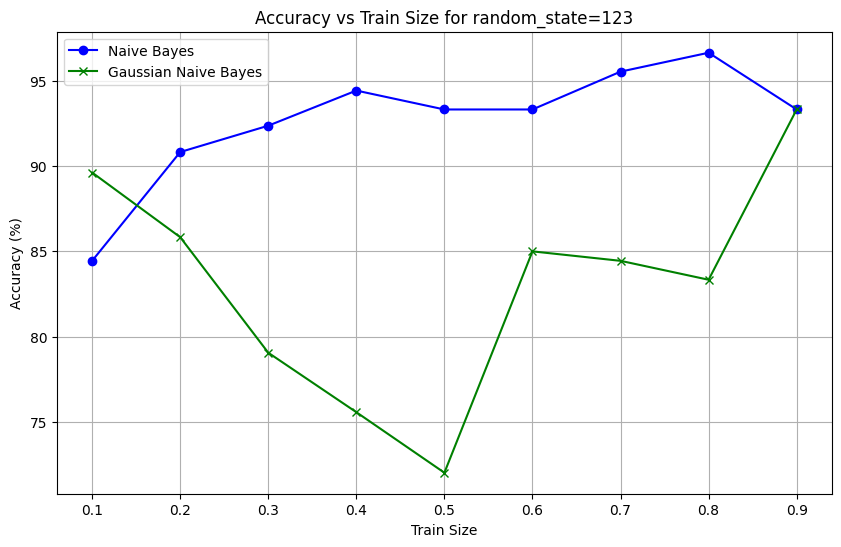


Testing with random_state = 42


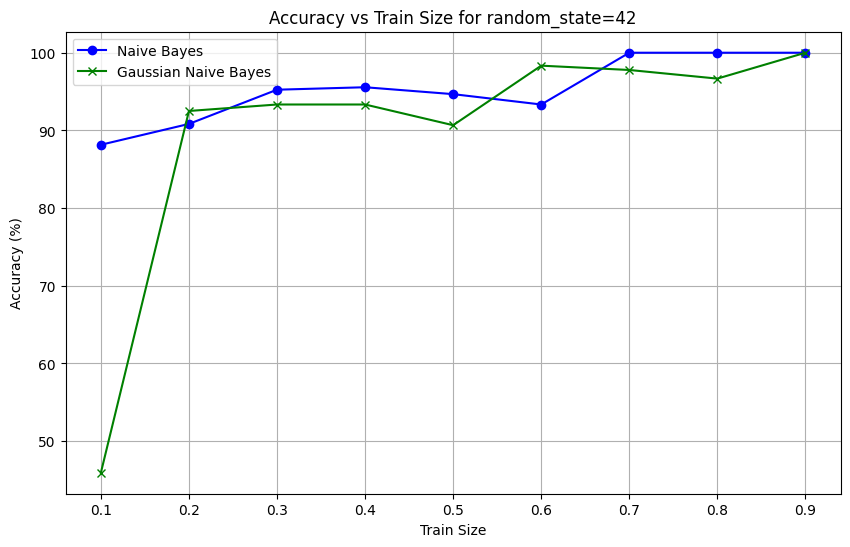


Testing with random_state = 7


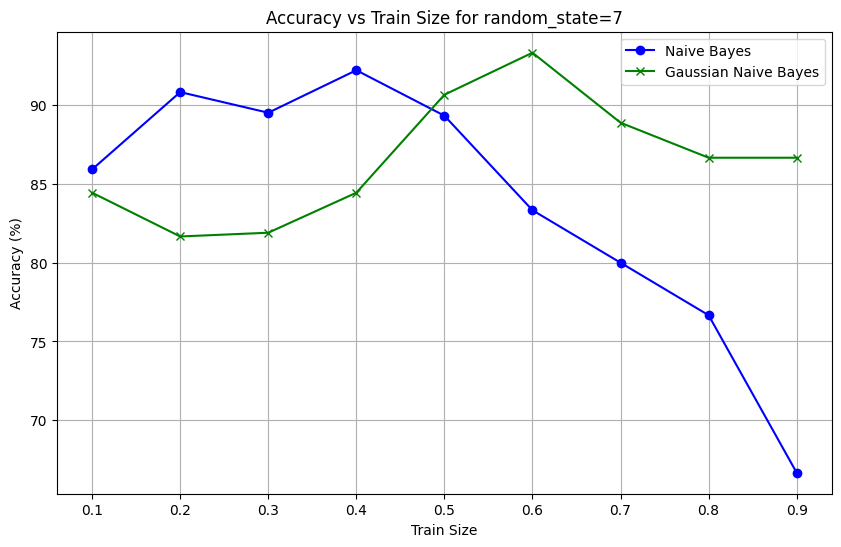


Testing with random_state = 99


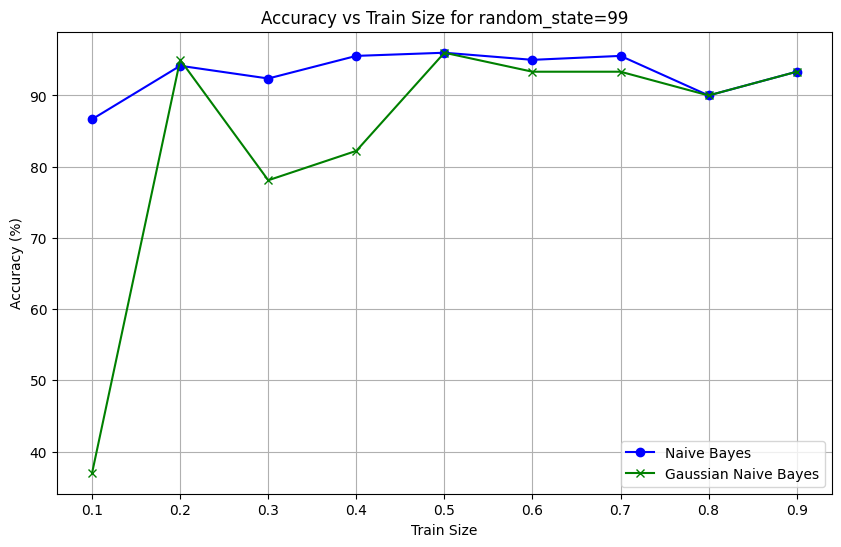

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def calculate_accuracy(x_train, x_test, y_train, y_test):
    nb_classifier = NaiveBayes()
    nb_classifier.build_classifier(x_train, y_train)
    discretized_samples = nb_classifier.discretize_features(x_test)
    nb_predictions = [nb_classifier.predict(sample) for sample in discretized_samples]
    nb_accuracy = accuracy_score(y_test, nb_predictions)

    gnb_classifier = GaussianNaiveBayes()
    gnb_classifier.build_classifier(x_train, y_train)
    gnb_predictions = [gnb_classifier.predict(sample) for sample in x_test]
    gnb_accuracy = accuracy_score(y_test, gnb_predictions)

    return nb_accuracy, gnb_accuracy

def test_accuracy_for_different_sizes_and_random_state(x, y, min_size=0.1, max_size=0.9, step=0.1, random_states=[123, 42, 7, 99]):
    for random_state in random_states:
        print(f"\nTesting with random_state = {random_state}")

        nb_accuracies = []
        gnb_accuracies = []
        train_sizes = np.arange(min_size, max_size + step, step)

        for train_size in train_sizes:
            x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
                x, y, train_size=train_size, test_size=1-train_size, random_state=random_state)

            nb_accuracy, gnb_accuracy = calculate_accuracy(x_train_split, x_test_split, y_train_split, y_test_split)

            nb_accuracies.append(nb_accuracy)
            gnb_accuracies.append(gnb_accuracy)

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.array(nb_accuracies) * 100, label="Naive Bayes", color='blue', marker='o')
        plt.plot(train_sizes, np.array(gnb_accuracies) * 100, label="Gaussian Naive Bayes", color='green', marker='x')
        plt.xlabel('Train Size')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy vs Train Size for random_state={random_state}')
        plt.legend()
        plt.grid(True)
        plt.show()

test_accuracy_for_different_sizes_and_random_state(x, y, random_states=[123, 42, 7, 99])


Testing for 2 bins...
Accuracy for 2 bins: 80.00%
Testing for 4 bins...
Accuracy for 4 bins: 93.33%
Testing for 6 bins...
Accuracy for 6 bins: 100.00%
Testing for 8 bins...
Accuracy for 8 bins: 93.33%
Testing for 10 bins...
Accuracy for 10 bins: 93.33%


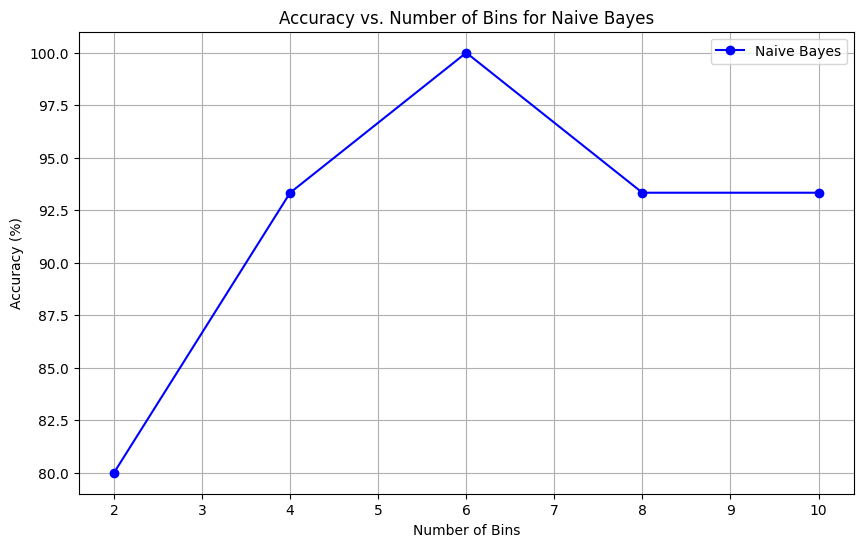

In [94]:
def test_accuracy_for_different_bins(x_train, x_test, y_train, y_test, bins_list):
    accuracies = []

    for bins in bins_list:
        print(f"Testing for {bins} bins...")
        nb_classifier = NaiveBayes(bins=bins)
        nb_classifier.build_classifier(x_train, y_train)

        discretized_samples = nb_classifier.discretize_features(x_test)
        nb_predictions = [nb_classifier.predict(sample) for sample in discretized_samples]

        nb_accuracy = accuracy_score(y_test, nb_predictions)
        accuracies.append(nb_accuracy)
        print(f"Accuracy for {bins} bins: {nb_accuracy * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(bins_list, np.array(accuracies) * 100, marker='o', color='blue', label='Naive Bayes')
    plt.xlabel('Number of Bins')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Number of Bins for Naive Bayes')
    plt.legend()
    plt.grid(True)
    plt.show()

bins_list = [2, 4, 6, 8, 10]
test_accuracy_for_different_bins(x_train, x_test, y_train, y_test, bins_list)

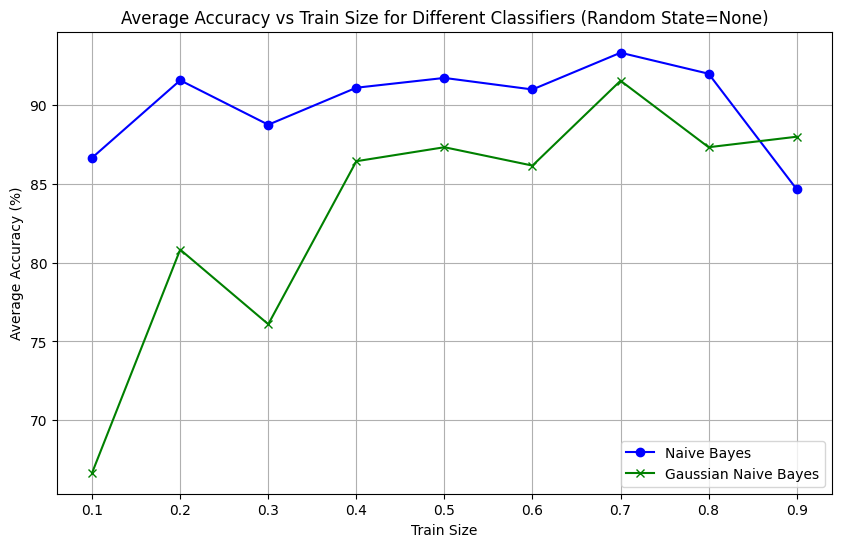

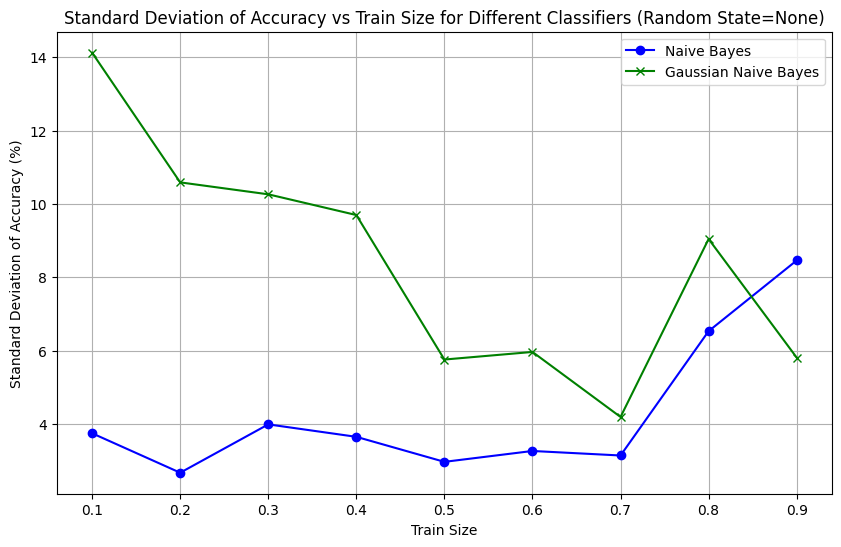

In [95]:
def test_accuracy_for_different_sizes_random_state_none(x, y, min_size=0.1, max_size=0.9, step=0.1, iterations=10):
    nb_accuracies = []
    gnb_accuracies = []
    nb_std_devs = []
    gnb_std_devs = []
    train_sizes = np.arange(min_size, max_size + step, step)

    for train_size in train_sizes:
        nb_accs = []
        gnb_accs = []
        for _ in range(iterations):
            x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
                x, y, train_size=train_size, test_size=1-train_size, random_state=None)

            nb_accuracy, gnb_accuracy = calculate_accuracy(x_train_split, x_test_split, y_train_split, y_test_split)

            nb_accs.append(nb_accuracy)
            gnb_accs.append(gnb_accuracy)

        nb_accuracies.append(np.mean(nb_accs))
        gnb_accuracies.append(np.mean(gnb_accs))

        nb_std_devs.append(np.std(nb_accs))
        gnb_std_devs.append(np.std(gnb_accs))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.array(nb_accuracies) * 100, label="Naive Bayes", color='blue', marker='o')
    plt.plot(train_sizes, np.array(gnb_accuracies) * 100, label="Gaussian Naive Bayes", color='green', marker='x')
    plt.xlabel('Train Size')
    plt.ylabel('Average Accuracy (%)')
    plt.title('Average Accuracy vs Train Size for Different Classifiers (Random State=None)')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.array(nb_std_devs) * 100, label="Naive Bayes", color='blue', marker='o')
    plt.plot(train_sizes, np.array(gnb_std_devs) * 100, label="Gaussian Naive Bayes", color='green', marker='x')
    plt.xlabel('Train Size')
    plt.ylabel('Standard Deviation of Accuracy (%)')
    plt.title('Standard Deviation of Accuracy vs Train Size for Different Classifiers (Random State=None)')
    plt.legend()
    plt.grid(True)
    plt.show()

test_accuracy_for_different_sizes_random_state_none(x, y)